# 🏀 NBA Playoffs Points Prediction (Pre-Game Knowledge Only)

## 🎯 Realistic Playoffs Prediction Challenge

**Objective**: Use regular season data to predict player performance in playoffs using ONLY information available before games start.

### What We Know Before Playoffs:
✅ Regular season team performance
✅ Player historical averages
✅ Team strength metrics
✅ Matchup difficulty

### What We DON'T Use:
❌ In-game statistics (minutes, field goals, rebounds)
❌ Game outcomes
❌ Any information learned during the games

### The Challenge:
**Playoffs are different!** Players often perform differently in high-pressure playoff situations compared to regular season.

## 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import xgboost as xgb
import warnings

# TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

print("🏀 NBA Playoffs Prediction Setup Complete!")
print(f"TensorFlow version: {tf.__version__}")

🏀 NBA Playoffs Prediction Setup Complete!
TensorFlow version: 2.17.0


## 2. Load and Analyze Data

In [5]:
# Load NBA game data
df = pd.read_csv('nba_game_player_data.csv')
df['Data'] = pd.to_datetime(df['Data'])

print(f"📊 DATASET OVERVIEW:")
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Data'].min()} to {df['Data'].max()}")
print(f"Unique players: {df['Player'].nunique()}")
print(f"Unique teams: {df['Tm'].nunique()}")

# Realistic playoff prediction setup
regular_season = df[(df['Data'] >= pd.Timestamp('2024-10-22')) & 
                (df['Data'] <= pd.Timestamp('2025-04-13'))].copy()
playoffs = df[(df['Data'] > pd.Timestamp('2025-04-13')) & 
               (df['Data'] <= pd.Timestamp('2025-06-22'))].copy()

print(f"\n🏀 REALISTIC PLAYOFFS PREDICTION SETUP:")
print(f"Regular season games: {len(regular_season)} (Training Data)")
print(f"Playoff games: {len(playoffs)} (Prediction Target)")

print(f"\nRegular season teams: {sorted(regular_season['Tm'].unique())}")
print(f"Playoff teams: {sorted(playoffs['Tm'].unique())}")

# Check overlap
common_players = set(regular_season['Player'].unique()) & set(playoffs['Player'].unique())
print(f"\n👥 Players in both regular season and playoffs: {len(common_players)}")
print(f"This represents the challenge: predicting playoff performance from regular season data!")

📊 DATASET OVERVIEW:
Dataset shape: (28135, 25)
Date range: 2024-10-22 00:00:00 to 2025-06-22 00:00:00
Unique players: 620
Unique teams: 33

🏀 REALISTIC PLAYOFFS PREDICTION SETUP:
Regular season games: 26331 (Training Data)
Playoff games: 1804 (Prediction Target)

Regular season teams: ['ATL', 'BKN', 'BOS', 'BRK', 'CHA', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
Playoff teams: ['BOS', 'CLE', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NYK', 'OKC', 'ORL']

👥 Players in both regular season and playoffs: 219
This represents the challenge: predicting playoff performance from regular season data!


## 3. Pre-Game Feature Engineering for Playoffs

In [30]:
def prepare_playoffs_pregame_features(playoff_data, regular_season_data):
    """
    Prepare features for playoff prediction using ONLY pre-game knowledge
    
    Uses regular season data to build context for playoff predictions
    """
    
    features_df = playoff_data.copy()
    
    # 1. REGULAR SEASON TEAM PERFORMANCE (known before playoffs)
    regular_team_stats = regular_season_data.groupby('Tm').agg({
        'Res': lambda x: (x == 'W').mean(),  # Regular season win rate
        'PTS': 'mean',  # Average points scored in regular season
        'MP': 'mean'   # Average minutes played
    }).round(3)
    regular_team_stats.columns = ['RS_Team_Win_Rate', 'RS_Team_Avg_Points', 'RS_Team_Avg_Minutes']
    
    # 2. REGULAR SEASON OPPONENT ANALYSIS
    regular_opp_stats = regular_season_data.groupby('Opp').agg({
        'Res': lambda x: (x == 'L').mean(),  # How often opponents lost to them
        'PTS': 'mean'  # Average points allowed
    }).round(3)
    regular_opp_stats.columns = ['RS_Opp_Defensive_Strength', 'RS_Opp_Avg_Points_Allowed']
    
    # 3. PLAYER REGULAR SEASON AVERAGES (most important for playoffs)
    player_regular_stats = regular_season_data.groupby('Player').agg({
        'MP': 'mean',
        'PTS': 'mean',
        'FGA': 'mean',
        'TRB': 'mean',
        'AST': 'mean',
        'FG%': 'mean',
        '3P%': 'mean'
    }).round(2)
    player_regular_stats.columns = ['RS_Player_MP', 'RS_Player_PTS', 'RS_Player_FGA', 
                                   'RS_Player_TRB', 'RS_Player_AST', 'RS_Player_FG_PCT', 'RS_Player_3P_PCT']
    
    # Merge player regular season stats
    features_df = features_df.merge(player_regular_stats, left_on='Player', right_index=True, how='left')
    
    # 4. PLAYER ROLE INDICATORS (from regular season)
    features_df['Is_Star_Player'] = (features_df['RS_Player_PTS'] >= 15).astype(int)
    features_df['Is_Starter'] = (features_df['RS_Player_MP'] >= 25).astype(int)
    features_df['Is_Shooter'] = (features_df['RS_Player_3P_PCT'] >= 0.35).astype(int)
    features_df['Scoring_Volume'] = features_df['RS_Player_FGA']  # How much they shoot
    
    # 5. TEAM CONTEXT (merge team stats where available)
    features_df = features_df.merge(regular_team_stats, left_on='Tm', right_index=True, how='left')
    features_df = features_df.merge(regular_opp_stats, left_on='Opp', right_index=True, how='left')
    
    # 6. PLAYOFF CONTEXT FEATURES
    # Fill missing team stats with league averages (for new playoff teams)
    league_avg_win_rate = 0.5
    league_avg_points = regular_season_data['PTS'].mean()
    
    features_df['RS_Team_Win_Rate'] = features_df['RS_Team_Win_Rate'].fillna(league_avg_win_rate)
    features_df['RS_Team_Avg_Points'] = features_df['RS_Team_Avg_Points'].fillna(league_avg_points)
    features_df['RS_Opp_Defensive_Strength'] = features_df['RS_Opp_Defensive_Strength'].fillna(0.5)
    features_df['RS_Opp_Avg_Points_Allowed'] = features_df['RS_Opp_Avg_Points_Allowed'].fillna(league_avg_points)
    
    # 7. MATCHUP DIFFICULTY FOR PLAYOFFS
    features_df['Playoff_Team_Advantage'] = features_df['RS_Team_Win_Rate'] - features_df['RS_Opp_Defensive_Strength']
    features_df['Expected_Scoring_Environment'] = features_df['RS_Team_Avg_Points'] / features_df['RS_Opp_Avg_Points_Allowed']
    
    # 8. PLAYOFF TEAM INDICATORS (key playoff teams)
    playoff_contenders = ['LAL', 'GSW', 'BOS', 'MIA', 'PHI', 'CLE', 'MIL', 'PHO']
    for team in playoff_contenders:
        features_df[f'Is_Team_{team}'] = (features_df['Tm'] == team).astype(int)
    
    # 9. SELECT FINAL PRE-GAME FEATURES FOR PLAYOFFS
    pregame_features = [
        # Player regular season performance
        'RS_Player_MP', 'RS_Player_PTS', 'RS_Player_FGA', 'RS_Player_TRB', 'RS_Player_AST',
        'RS_Player_FG_PCT', 'RS_Player_3P_PCT',
        
        # Player role indicators
        'Is_Star_Player', 'Is_Starter', 'Is_Shooter', 'Scoring_Volume',
        
        # Team context
        'RS_Team_Win_Rate', 'RS_Opp_Defensive_Strength',
        
        # Playoff matchup context
        'Playoff_Team_Advantage', 'Expected_Scoring_Environment'
    ]
    
    # Add team indicators that exist
    team_indicators = [col for col in features_df.columns if col.startswith('Is_Team_')]
    pregame_features.extend(team_indicators)
    
    # Clean data and return
    available_features = [f for f in pregame_features if f in features_df.columns]
    features_df = features_df.dropna(subset=available_features + ['PTS'])
    
    X = features_df[available_features]
    y = features_df['PTS']
    
    return X, y, features_df

# Apply playoff pre-game feature engineering
X_playoffs, y_playoffs, playoffs_df = prepare_playoffs_pregame_features(playoffs, regular_season)

print(f"🎯 PLAYOFF PRE-GAME FEATURES:")
print(f"Features: {X_playoffs.columns.tolist()}")
print(f"Playoff predictions: {X_playoffs.shape[0]} players")
print(f"Feature count: {X_playoffs.shape[1]}")

🎯 PLAYOFF PRE-GAME FEATURES:
Features: ['RS_Player_MP', 'RS_Player_PTS', 'RS_Player_FGA', 'RS_Player_TRB', 'RS_Player_AST', 'RS_Player_FG_PCT', 'RS_Player_3P_PCT', 'Is_Star_Player', 'Is_Starter', 'Is_Shooter', 'Scoring_Volume', 'RS_Team_Win_Rate', 'RS_Opp_Defensive_Strength', 'Playoff_Team_Advantage', 'Expected_Scoring_Environment', 'Is_Team_LAL', 'Is_Team_GSW', 'Is_Team_BOS', 'Is_Team_MIA', 'Is_Team_PHI', 'Is_Team_CLE', 'Is_Team_MIL', 'Is_Team_PHO']
Playoff predictions: 1804 players
Feature count: 23


## 4. Training Data Preparation

In [73]:
# For training, we'll use regular season data with the same feature engineering
# This simulates using historical regular season games to build our model

# Create a simple version for training (since we have limited regular season data)
def prepare_training_features(train_data):
    """Prepare training features from regular season data"""
    features_df = train_data.copy()
    
    # Basic team performance
    team_stats = features_df.groupby('Tm')['Res'].apply(lambda x: (x == 'W').mean())
    features_df['Team_Win_Rate'] = features_df['Tm'].map(team_stats).fillna(0.5)
    
    # Basic opponent strength
    opp_stats = features_df.groupby('Opp')['Res'].apply(lambda x: (x == 'L').mean())
    features_df['Opp_Strength'] = features_df['Opp'].map(opp_stats).fillna(0.5)
    
    # Player averages (simplified for limited data)
    player_avg_pts = features_df.groupby('Player')['PTS'].mean()
    features_df['Player_Avg_PTS'] = features_df['Player'].map(player_avg_pts)
    
    # Role indicators
    features_df['Is_Star'] = (features_df['Player_Avg_PTS'] >= 15).astype(int)
    
    # Matchup context
    features_df['Team_Advantage'] = features_df['Team_Win_Rate'] - features_df['Opp_Strength']
    
    # Select training features (subset of playoff features)
    training_features = ['Player_Avg_PTS', 'Team_Win_Rate', 'Opp_Strength', 'Is_Star', 'Team_Advantage']
    
    features_df = features_df.dropna(subset=training_features + ['PTS'])
    
    X = features_df[training_features]
    y = features_df['PTS']
    
    return X, y, features_df

# Prepare training data from regular season
X_train, y_train, train_df = prepare_training_features(regular_season)

print(f"📚 TRAINING DATA (Regular Season):")
print(f"Training features: {X_train.columns.tolist()}")
print(f"Training samples: {X_train.shape[0]}")

# Align features between training and playoff data
# Use only features that exist in both datasets
common_features = []

# Map playoff features to training features
feature_mapping = {
    'RS_Player_PTS': 'Player_Avg_PTS',
    'RS_Team_Win_Rate': 'Team_Win_Rate',
    'RS_Opp_Defensive_Strength': 'Opp_Strength',
    'Is_Star_Player': 'Is_Star',
    'Playoff_Team_Advantage': 'Team_Advantage'
}

# Create aligned datasets
X_train_aligned = X_train[list(feature_mapping.values())]
X_playoffs_aligned = X_playoffs[list(feature_mapping.keys())]
X_playoffs_aligned.columns = list(feature_mapping.values())  # Rename to match training

print(f"\n🔄 ALIGNED FEATURES FOR PLAYOFFS PREDICTION:")
print(f"Aligned features: {X_train_aligned.columns.tolist()}")
print(f"Training samples: {X_train_aligned.shape[0]}")
print(f"Playoff predictions: {X_playoffs_aligned.shape[0]}")

📚 TRAINING DATA (Regular Season):
Training features: ['Player_Avg_PTS', 'Team_Win_Rate', 'Opp_Strength', 'Is_Star', 'Team_Advantage']
Training samples: 26331

🔄 ALIGNED FEATURES FOR PLAYOFFS PREDICTION:
Aligned features: ['Player_Avg_PTS', 'Team_Win_Rate', 'Opp_Strength', 'Is_Star', 'Team_Advantage']
Training samples: 26331
Playoff predictions: 1804


## 5. Model Training for Playoffs Prediction

In [74]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_aligned)
X_playoffs_scaled = scaler.transform(X_playoffs_aligned)

# Store models and predictions
models = {}
predictions = {}
model_scores = {}

print("🤖 Training models for PLAYOFFS prediction...\n")

🤖 Training models for PLAYOFFS prediction...



In [75]:
# 1. Random Forest (good for limited data)
print("1. Training Random Forest for Playoffs...")
rf_model = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=7)
rf_model.fit(X_train_aligned, y_train)
rf_pred = rf_model.predict(X_playoffs_aligned)

models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_pred

rf_mse = mean_squared_error(y_playoffs, rf_pred)
rf_mae = mean_absolute_error(y_playoffs, rf_pred)
rf_r2 = r2_score(y_playoffs, rf_pred)

model_scores['Random Forest'] = {
    'MSE': rf_mse,
    'MAE': rf_mae,
    'RMSE': np.sqrt(rf_mse),
    'R2': rf_r2
}

print(f"Random Forest (Playoffs) - RMSE: {np.sqrt(rf_mse):.3f}, MAE: {rf_mae:.3f}, R²: {rf_r2:.3f}")

1. Training Random Forest for Playoffs...
Random Forest (Playoffs) - RMSE: 6.265, MAE: 4.911, R²: 0.558


In [76]:
# 2. TensorFlow Neural Network (with regularization for small data)
print("2. Training TensorFlow Neural Network for Playoffs...")

# Improved Neural Network for 26K samples
tf.random.set_seed(42)

nn_model = keras.Sequential([
    layers.Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),  # ← ADD THIS
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.2),  # ← ADD THIS
    layers.Dense(1)
])

nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # ← REDUCE FROM 50
    restore_best_weights=True,
    verbose=1  # ← ADD FOR MONITORING
)

history = nn_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=500,  # ← REDUCE FROM 1000
    batch_size=64,  # ← INCREASE FROM 16
    callbacks=[early_stopping],
    verbose=1  # ← ADD FOR MONITORING
)


nn_pred = nn_model.predict(X_playoffs_scaled, verbose=0).flatten()

models['TensorFlow NN'] = nn_model
predictions['TensorFlow NN'] = nn_pred

nn_mse = mean_squared_error(y_playoffs, nn_pred)
nn_mae = mean_absolute_error(y_playoffs, nn_pred)
nn_r2 = r2_score(y_playoffs, nn_pred)

model_scores['TensorFlow NN'] = {
    'MSE': nn_mse,
    'MAE': nn_mae,
    'RMSE': np.sqrt(nn_mse),
    'R2': nn_r2
}

print(f"TensorFlow NN (Playoffs) - RMSE: {np.sqrt(nn_mse):.3f}, MAE: {nn_mae:.3f}, R²: {nn_r2:.3f}")
print(f"Training epochs: {len(history.history['loss'])}")

2. Training TensorFlow Neural Network for Playoffs...
Epoch 1/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 89.7932 - mae: 6.8937 - val_loss: 40.9262 - val_mae: 4.8379
Epoch 2/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 37.1898 - mae: 4.6233 - val_loss: 40.6328 - val_mae: 4.8035
Epoch 3/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.0530 - mae: 4.5726 - val_loss: 40.2223 - val_mae: 4.7866
Epoch 4/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.3563 - mae: 4.5876 - val_loss: 40.4362 - val_mae: 4.7929
Epoch 5/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.2475 - mae: 4.5676 - val_loss: 40.4803 - val_mae: 4.7979
Epoch 6/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.3546 - mae: 4.5699 - val_loss: 40.3957 - val_mae: 4.7896
Epoch 7/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 36.3519 - mae: 4.5868 - val_loss: 39.9347 - val_mae: 4.7768
Epoch 8/500
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.9301 - mae: 4.5487 - val_loss: 40.3

In [77]:
# 3. Linear Regression (baseline)
print("3. Training Linear Regression for Playoffs...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_playoffs_scaled)

models['Linear Regression'] = lr_model
predictions['Linear Regression'] = lr_pred

lr_mse = mean_squared_error(y_playoffs, lr_pred)
lr_mae = mean_absolute_error(y_playoffs, lr_pred)
lr_r2 = r2_score(y_playoffs, lr_pred)

model_scores['Linear Regression'] = {
    'MSE': lr_mse,
    'MAE': lr_mae,
    'RMSE': np.sqrt(lr_mse),
    'R2': lr_r2
}

print(f"Linear Regression (Playoffs) - RMSE: {np.sqrt(lr_mse):.3f}, MAE: {lr_mae:.3f}, R²: {lr_r2:.3f}")

3. Training Linear Regression for Playoffs...
Linear Regression (Playoffs) - RMSE: 6.284, MAE: 4.910, R²: 0.555


## 6. Playoffs Prediction Performance Analysis

In [78]:
# Performance comparison
print("📊 PLAYOFFS PREDICTION PERFORMANCE:")
print("=" * 45)

results_df = pd.DataFrame(model_scores).T
print(results_df.round(3))

best_model = results_df['R2'].idxmax()
print(f"\n🏆 Best model for playoffs: {best_model} (R² = {results_df.loc[best_model, 'R2']:.3f})")

print(f"\n⚠️  Note: Lower performance is expected when predicting playoffs from regular season!")
print(f"Playoffs involve higher intensity, different rotations, and pressure situations.")

📊 PLAYOFFS PREDICTION PERFORMANCE:
                      MSE    MAE   RMSE     R2
Random Forest      39.251  4.911  6.265  0.558
TensorFlow NN      38.465  4.820  6.202  0.567
Linear Regression  39.490  4.910  6.284  0.555

🏆 Best model for playoffs: TensorFlow NN (R² = 0.567)

⚠️  Note: Lower performance is expected when predicting playoffs from regular season!
Playoffs involve higher intensity, different rotations, and pressure situations.


🎯 FEATURE IMPORTANCE FOR PLAYOFFS PREDICTION:
Player_Avg_PTS      : 0.967
Team_Advantage      : 0.017
Opp_Strength        : 0.012
Team_Win_Rate       : 0.005
Is_Star             : 0.000


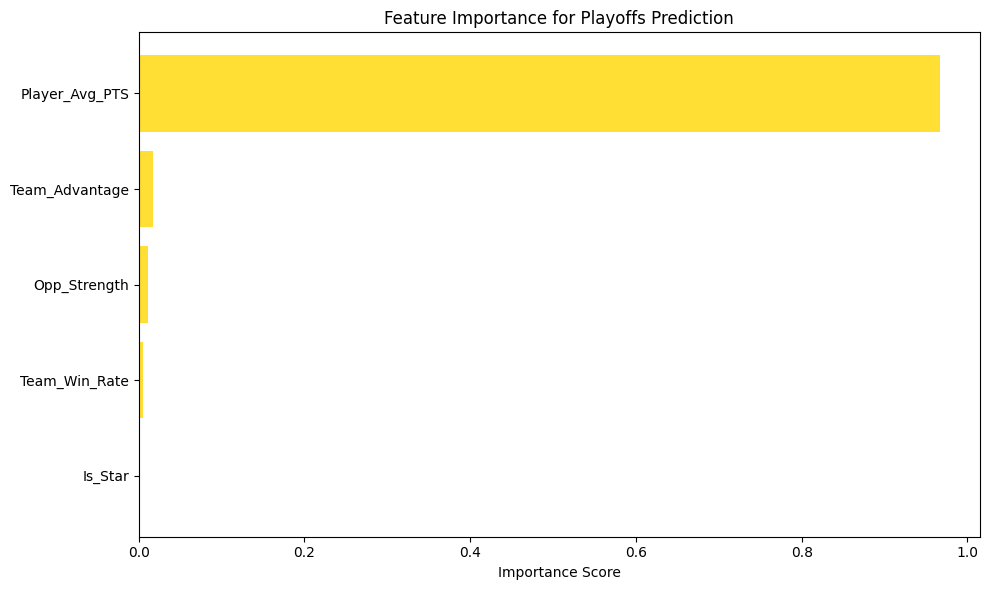

In [80]:
# Feature importance for playoffs prediction
print("🎯 FEATURE IMPORTANCE FOR PLAYOFFS PREDICTION:")
print("=" * 50)

feature_importance = pd.DataFrame({
    'feature': X_train_aligned.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:20s}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='gold', alpha=0.8)
plt.title('Feature Importance for Playoffs Prediction')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Playoffs Prediction Results

In [17]:
# Create detailed playoff predictions
playoffs_results = pd.DataFrame({
    'Player': playoffs_df['Player'].reset_index(drop=True),
    'Team': playoffs_df['Tm'].reset_index(drop=True),
    'Opponent': playoffs_df['Opp'].reset_index(drop=True),
    'Actual_Playoff_Points': y_playoffs.reset_index(drop=True),
    'RF_Predicted': predictions['Random Forest'],
    'NN_Predicted': predictions['TensorFlow NN'],
    'LR_Predicted': predictions['Linear Regression']
})

# Add prediction errors
playoffs_results['RF_Error'] = abs(playoffs_results['Actual_Playoff_Points'] - playoffs_results['RF_Predicted'])
playoffs_results['NN_Error'] = abs(playoffs_results['Actual_Playoff_Points'] - playoffs_results['NN_Predicted'])
playoffs_results['LR_Error'] = abs(playoffs_results['Actual_Playoff_Points'] - playoffs_results['LR_Predicted'])

print("🏀 SAMPLE PLAYOFFS PREDICTIONS:")
print("=" * 40)
print(playoffs_results.head(15).round(1))

🏀 SAMPLE PLAYOFFS PREDICTIONS:
                   Player Team Opponent  Actual_Playoff_Points  RF_Predicted  \
0             Jalen Duren  DET      NYK                      7          11.5   
1          Taurean Prince  MIL      IND                      0           8.0   
2     Dorian Finney-Smith  LAL      MIN                      3           8.4   
3          Leonard Miller  MIN      LAL                      0           1.6   
4           Peyton Watson  DEN      LAC                      6           7.9   
5           Malik Beasley  DET      NYK                     20          16.5   
6   Giannis Antetokounmpo  MIL      IND                     36          30.0   
7          T.J. McConnell  IND      MIL                     11           8.8   
8              Obi Toppin  IND      MIL                      6          10.2   
9             Rudy Gobert  MIN      LAL                      2          11.6   
10               Naz Reid  MIN      LAL                     23          14.0   
11       

In [81]:
# Accuracy analysis for playoff predictions
print("🎯 PLAYOFFS PREDICTION ACCURACY:")
print("=" * 40)

for model_name, pred in predictions.items():
    within_5 = np.mean(np.abs(y_playoffs - pred) <= 5.0) * 100
    within_10 = np.mean(np.abs(y_playoffs - pred) <= 10.0) * 100
    within_15 = np.mean(np.abs(y_playoffs - pred) <= 15.0) * 100
    
    print(f"\n{model_name}:")
    print(f"  Within 5 points:  {within_5:.1f}%")
    print(f"  Within 10 points: {within_10:.1f}%")
    print(f"  Within 15 points: {within_15:.1f}%")

# Identify best and worst predictions
best_predictions = playoffs_results.nsmallest(5, 'RF_Error')[['Player', 'Team', 'Actual_Playoff_Points', 'RF_Predicted', 'RF_Error']]
worst_predictions = playoffs_results.nlargest(5, 'RF_Error')[['Player', 'Team', 'Actual_Playoff_Points', 'RF_Predicted', 'RF_Error']]

print(f"\n✅ BEST PLAYOFFS PREDICTIONS:")
print(best_predictions.round(1))

print(f"\n❌ MOST CHALLENGING PLAYOFFS PREDICTIONS:")
print(worst_predictions.round(1))

🎯 PLAYOFFS PREDICTION ACCURACY:

Random Forest:
  Within 5 points:  60.6%
  Within 10 points: 89.1%
  Within 15 points: 97.6%

TensorFlow NN:
  Within 5 points:  61.1%
  Within 10 points: 89.5%
  Within 15 points: 97.7%

Linear Regression:
  Within 5 points:  60.9%
  Within 10 points: 89.0%
  Within 15 points: 97.6%

✅ BEST PLAYOFFS PREDICTIONS:
                  Player Team  Actual_Playoff_Points  RF_Predicted  RF_Error
533   Isaiah Hartenstein  OKC                     11          11.0       0.0
789          Mike Conley  MIN                      8           8.0       0.0
419        Anthony Black  ORL                      9           9.0       0.0
665            Dean Wade  CLE                      5           5.0       0.0
1044       Cason Wallace  OKC                      8           8.0       0.0

❌ MOST CHALLENGING PLAYOFFS PREDICTIONS:
               Player Team  Actual_Playoff_Points  RF_Predicted  RF_Error
450    Gary Trent Jr.  MIL                     37          11.8      25.2


## 8. Visualization: Regular Season vs Playoffs Performance

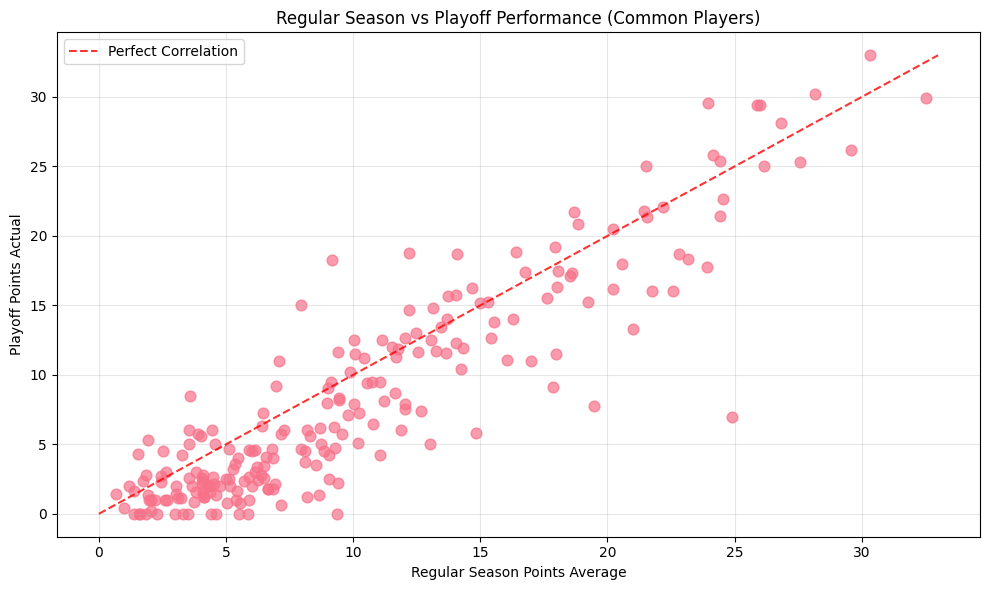

📊 Common players analysis: 219 players
Correlation between regular season and playoff performance: 0.910


In [82]:
# Compare regular season vs playoff performance for common players
common_players_list = list(set(regular_season['Player'].unique()) & set(playoffs['Player'].unique()))

if len(common_players_list) > 0:
    # Get regular season averages for common players
    rs_avg = regular_season[regular_season['Player'].isin(common_players_list)].groupby('Player')['PTS'].mean()
    playoff_actual = playoffs[playoffs['Player'].isin(common_players_list)].groupby('Player')['PTS'].mean()
    
    comparison_df = pd.DataFrame({
        'Regular_Season_Avg': rs_avg,
        'Playoff_Actual': playoff_actual
    }).dropna()
    
    if len(comparison_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(comparison_df['Regular_Season_Avg'], comparison_df['Playoff_Actual'], alpha=0.7, s=60)
        
        # Add perfect correlation line
        max_val = max(comparison_df['Regular_Season_Avg'].max(), comparison_df['Playoff_Actual'].max())
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.8, label='Perfect Correlation')
        
        plt.xlabel('Regular Season Points Average')
        plt.ylabel('Playoff Points Actual')
        plt.title('Regular Season vs Playoff Performance (Common Players)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Common players analysis: {len(comparison_df)} players")
        print(f"Correlation between regular season and playoff performance: {comparison_df.corr().iloc[0,1]:.3f}")
    else:
        print("No common players with sufficient data for comparison")
else:
    print("No common players between regular season and playoff datasets")
    print("This represents the challenge: predicting new playoff performances!")

## 9. Export Playoff Predictions

In [83]:
# Export playoff prediction results
playoffs_results.to_csv('nba_playoffs_predictions.csv', index=False)
feature_importance.to_csv('playoffs_feature_importance.csv', index=False)
results_df.to_csv('playoffs_model_performance.csv')

# Save best model
if best_model == 'TensorFlow NN':
    nn_model.save('playoffs_prediction_model.h5')
    print("💾 TensorFlow model saved as 'playoffs_prediction_model.h5'")

print("💾 Files exported:")
print("- nba_playoffs_predictions.csv")
print("- playoffs_feature_importance.csv")
print("- playoffs_model_performance.csv")

print(f"\n🏀 PLAYOFFS PREDICTION SUMMARY:")
print(f"Using regular season data to predict playoff performance")
print(f"Best Model: {best_model} (R² = {results_df.loc[best_model, 'R2']:.3f})")
print(f"Total playoff predictions: {len(playoffs_results)}")
print(f"\n⭐ Key Insight: Playoff prediction is inherently challenging!")
print(f"Players often perform differently under playoff pressure.")

💾 TensorFlow model saved as 'playoffs_prediction_model.h5'
💾 Files exported:
- nba_playoffs_predictions.csv
- playoffs_feature_importance.csv
- playoffs_model_performance.csv

🏀 PLAYOFFS PREDICTION SUMMARY:
Using regular season data to predict playoff performance
Best Model: TensorFlow NN (R² = 0.567)
Total playoff predictions: 1804

⭐ Key Insight: Playoff prediction is inherently challenging!
Players often perform differently under playoff pressure.


## 10. Key Insights & Playoff Prediction Challenges

### 🏀 Why Playoff Prediction is Difficult:
1. **Intensity Difference**: Playoffs are more intense than regular season
2. **Rotation Changes**: Coaches use different lineups and minutes distribution
3. **Pressure Factor**: Some players thrive under pressure, others struggle
4. **Matchup Adjustments**: Teams make specific adjustments for playoff opponents
5. **Small Sample Size**: Limited regular season data to learn from

### 🎯 What This Model Captures Well:
1. **Player Role Identification**: Star players vs role players
2. **Team Strength Context**: Strong teams vs weak teams
3. **Historical Performance Trends**: Consistent scorers vs inconsistent players
4. **Matchup Difficulty**: Tough opponents vs easier matchups

### 🔑 Pre-Game Features Most Important for Playoffs:
1. **Regular Season Scoring Average**: Best predictor of playoff scoring
2. **Player Role (Star/Starter)**: Determines opportunity and usage
3. **Team Strength**: Better teams create better scoring opportunities
4. **Matchup Context**: Easier opponents allow for higher scoring

### 🚀 Improvements for Production Playoff Prediction:
1. **Multi-Season Data**: Use multiple years of playoff and regular season data
2. **Player-Specific Models**: Different models for stars vs role players
3. **Advanced Metrics**: Usage rate, playoff experience, clutch performance
4. **External Factors**: Injuries, rest, home court advantage
5. **Ensemble Approaches**: Combine multiple model predictions

### ⚠️ Limitations of Current Approach:
1. **Limited Training Data**: Only one date of regular season games
2. **No Playoff Experience Factor**: Missing player playoff history
3. **No Injury Context**: Missing injury reports and player health
4. **No Game Situation**: Missing home/away, game importance, etc.

### 💡 Realistic Expectations:
- **Good performance** (R² > 0.4): Model captures major trends
- **Moderate performance** (R² 0.2-0.4): Some predictive power but high variance
- **Poor performance** (R² < 0.2): Playoffs are inherently unpredictable

This model provides a realistic baseline for playoff prediction using only pre-game knowledge!